![](https://media.hswstatic.com/eyJidWNrZXQiOiJjb250ZW50Lmhzd3N0YXRpYy5jb20iLCJrZXkiOiJnaWZcL29ubGluZS10cmFkaW5nLmpwZyIsImVkaXRzIjp7InJlc2l6ZSI6eyJ3aWR0aCI6ODI4fX19)

# Introduction

Huge Stock Market is a dataset of daily dollar price of stocks and ETF's (open, max, min, close and volume) from thousands of markets. The goal of this project is to develop a trading bot using Q Learning, to decide, through open, max, min and close values ​​of each day, if buy, hold or sell the stock. The traded prices are the close prices, on a daily basis.

## Data Visualization

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os

In [2]:
# read data from file
def read_data(path):
  market_prices = []
  with open(path) as f:
      line = f.readline()
      while True:
          line = f.readline()
          if not line:
              break
          parts = line.split(',')
          market_prices.append(np.array(parts[1:5]).astype(float))

  return market_prices

In [3]:
# plot a market
def plot_market(file, market_prices):
    complement = 'profit'
    flRead = False
    if market_prices == None:
        market_prices = read_data(file)
        complement = 'prices'
        flRead = True
    
    if(flRead):
        lineObjects = plt.plot(market_prices, linestyle = '-')
        plt.legend(iter(lineObjects), ('open', 'max', 'min', 'close'))
    else:
        plt.plot(market_prices, linestyle = '-', label = 'profit')
        plt.legend(loc='best')
        
    plt.ylabel(f'{file} {complement} (US$)')
    plt.xlabel('days')

    plt.show()
    
    return

### IBM daily dollar prices

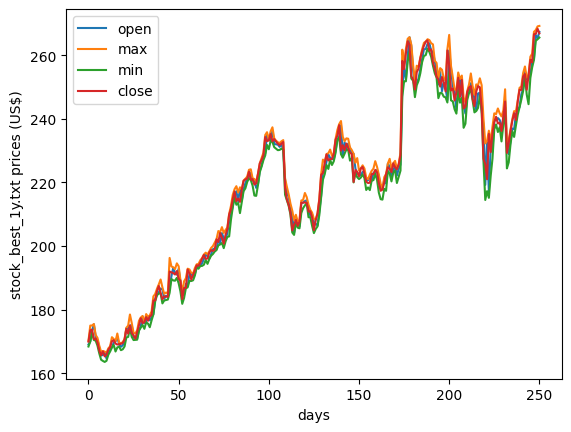

In [4]:
plot_market('stock_best_1y.txt', None)

Now let's implement the bot

# Agent

In [5]:
class QLearningTable:
    def __init__(self, actions, learning_rate, reward_decay, e_greedy):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.uniform() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]

            # some actions may have the same value, randomly choose on in these actions
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)  # update

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

# Environment

In [6]:
max_range = 1 # range of days

class Market(object):
  def __init__(self, data):
    super(Market, self).__init__()
    self.action_space = ['buy', 'hold', 'sell']
    self.n_actions = len(self.action_space)
    self.total_profit = 0
    self.profit = 0
    self.market_prices = None
    self.balance = 50000
    self.inventory = []
    self.range = [0, max_range]
    self.total_trades = 0
    self.profits_record = [0]

  def reset(self):
    self.profit = 0
    self.range = [0, max_range]
    self.market_prices = None
    self.balance = 50000
    self.inventory = []
    self.profits_record = [0]

  def step(self, action):
    reward = 0
    profit = 0
    current_price = self.market_prices[self.range[1]-1][3] # close value of the day
    
    # execute action
    flResult = False

    if action == 0: # buy
        if self.balance > current_price:
            self.balance -= current_price
            self.inventory.append(current_price)
            flResult = True
    elif action == 2: # sell
        if len(self.inventory) > 0:
            self.balance += current_price
            bought_price = self.inventory.pop(0)
            profit = current_price - bought_price
            reward = profit
            flResult = True
            
            self.total_profit += profit
            self.profit += profit
            self.total_trades +=1
    self.profits_record.append(self.profit)

    # check if next state is terminal
    if self.range[1] < len(self.market_prices):
      self.range[0] += 1
      self.range[1] += 1
      next_state = self.market_prices[self.range[0] : self.range[1]]
      done = False
    else:
      done = True
      next_state = 'terminal'

    # reward function 
    current_portfolio_value = len(self.inventory) * current_price + self.balance
    unrealized_profit = current_portfolio_value - 50000 # current portifolio subtracted by initial balance value
    
    if(flResult):
        reward += unrealized_profit
    else:
        reward -= self.treasury_bond_daily_return_rate() * self.balance  # missing opportunity
    
    return next_state, reward, done

  def treasury_bond_daily_return_rate(self):
    r_year = 2.75 / 100  # approximate annual U.S. Treasury bond return rate
    return (1 + r_year)**(1 / 365) - 1

# Machine Learning

## Model

In [7]:
class Model:
  def fit(self, RL, env, data):
    # instantiate environment and initial state
    env.market_prices = data
    state = env.market_prices[env.range[0] : env.range[1]]
    if len(state) != max_range: # clean dirty states
        return

    while True:
      # normalize states, choose action, step and learn
      state = self.normalize(state)
      action = RL.choose_action(str(state))
      next_state, reward, done = env.step(action)

      if next_state != 'terminal':
          next_state = self.normalize(next_state)
          RL.learn(str(state), action, reward, str(next_state))

      state = next_state

      if done:
        break

  def predict(self, RL, env, data):
    # instantiate environment and initial state
    env.market_prices = data
    state = env.market_prices[env.range[0] : env.range[1]]
    if len(state) != max_range: # clean dirty states
        return
    rewards = []

    while True:
      # normalize state, choose action and step
      state = self.normalize(state)
      RL.check_state_exist(str(state))

      # choose best action
      state_action = RL.q_table.loc[str(state), :]

      # some actions may have the same value, randomly choose on in these actions
      action = np.random.choice(state_action[state_action == np.max(state_action)].index)

      next_state, reward, done = env.step(action)

      rewards.append(reward)

      state = next_state

      if done:
        break
        
    return rewards

  # normalize a state
  def normalize(self, data): 
    data = (data - np.min(data))/(np.max(data) - np.min(data))
    return np.round(data, 1)

## Fit

In [8]:
from os import listdir
from os.path import isfile, join

In [9]:
# show the results after train or predict an entire market
def print_results(env):
  print(f'Total profit: US$ {"{0:.2f}".format(env.total_profit)}')
  print(f'Total trades: {env.total_trades}')

In [10]:
# instantiate environment, agent and model
env = Market(None)
RL = QLearningTable(actions=list(range(env.n_actions)), learning_rate=0.01, reward_decay=0.9, e_greedy=0.9)
model = Model()

In [11]:
import warnings
warnings.filterwarnings('ignore')

# instantiate record variables

train_profits_record_per_episodes = [0]
test_profits_record_per_episodes = [0]

train_max_market_profit = [None, float('-inf')]
train_min_market_profit = [None, float('inf')]

test_max_market_profit = [None, float('-inf')]
test_min_market_profit = [None, float('inf')]

i=0
# train and evaluate
for dir, _, files in os.walk('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks'):
    limit = int(len(files)*0.8)
    for file in files:
        if i < limit: # 80% of episodes for train
            # train
            print(f'Training with {file}...')
            market_prices = read_data(os.path.join(dir, file))
            model.fit(RL, env, market_prices)
            
            # record results
            print_results(env)
            train_profits_record_per_episodes.append(env.total_profit)
            if(env.profit > train_max_market_profit[1]):
                train_max_market_profit = [file, env.profit, env.profits_record]
            if(env.profit < train_min_market_profit[1]):
                train_min_market_profit = [file, env.profit, env.profits_record]
        
            env.reset()
        elif i == limit: # 20% of episodes for test
            # reset trade records
            env.total_profit = 0
            env.total_trades = 0
            # test
            print(f'Predicting {file}...')
            market_prices = read_data(os.path.join(dir, file))
            model.predict(RL, env, market_prices)

            # record results
            print_results(env)
            test_profits_record_per_episodes.append(env.total_profit)
            if(env.profit > test_max_market_profit[1]):
                test_max_market_profit = [file, env.profit, env.profits_record]
            if(env.profit < test_min_market_profit[1]):
                test_min_market_profit = [file, env.profit, env.profits_record]
                
            env.reset()
        else: # test
            print(f'Predicting {file}...')
            market_prices = read_data(os.path.join(dir, file))
            model.predict(RL, env, market_prices)

            # record results
            print_results(env)
            test_profits_record_per_episodes.append(env.total_profit)
            if(env.profit > test_max_market_profit[1]):
                test_max_market_profit = [file, env.profit, env.profits_record]
            if(env.profit < test_min_market_profit[1]):
                test_min_market_profit = [file, env.profit, env.profits_record]
                
            env.reset()
        i+=1

Training with ufi.us.txt...

Total profit: US$ 855.44

Total trades: 675

Training with vfl.us.txt...

Total profit: US$ 868.06

Total trades: 1444

Training with sohu.us.txt...

Total profit: US$ 1605.99

Total trades: 2558

Training with rdcm.us.txt...

Total profit: US$ 1701.28

Total trades: 3461

Training with virt.us.txt...

Total profit: US$ 1701.03

Total trades: 3687

Training with hylb.us.txt...

Total profit: US$ 1704.64

Total trades: 3746

Training with skt.us.txt...

Total profit: US$ 1833.88

Total trades: 4902

Training with asix.us.txt...

Total profit: US$ 1993.06

Total trades: 5003

Training with mac.us.txt...

Total profit: US$ 1979.86

Total trades: 6202

Training with gut.us.txt...

Total profit: US$ 1998.18

Total trades: 7324

Training with ngs.us.txt...

Total profit: US$ 2176.88

Total trades: 8410

Training with vpg.us.txt...

Total profit: US$ 2310.69

Total trades: 9060

Training with ibtx.us.txt...

Total profit: US$ 2334.92

Total trades: 9468

Training 

## Evaluate

In [12]:
# show results of test
print_results(env)

Total profit: US$ 3252374.22

Total trades: 1243469


# Results

The total profit on test set was **US$ 3252374.22** after **1243469 trades**.

## Train results

### Train profit by episodes

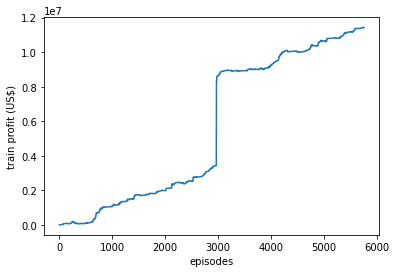

In [13]:
plt.plot(train_profits_record_per_episodes, linestyle = '-')
plt.ylabel('train profit (US$)')
plt.xlabel('episodes')

plt.show()

### Most lucrative market on train - Prices by time

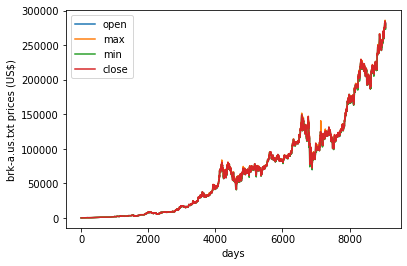

In [14]:
plot_market(train_max_market_profit[0], None)

### Most lucrative market on train - Profit by time

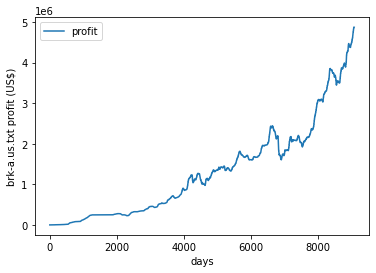

In [15]:
plot_market(train_max_market_profit[0], train_max_market_profit[2])

### Less lucrative market on train - Prices by time

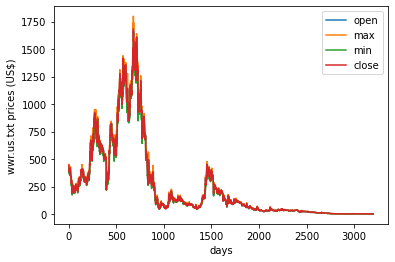

In [16]:
plot_market(train_min_market_profit[0], None)

### Less lucrative market on train - Profit by time

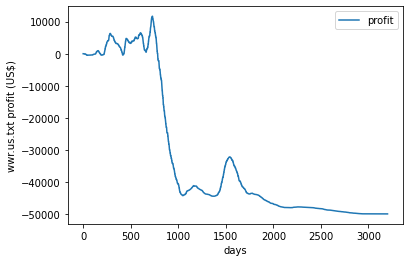

In [17]:
plot_market(train_min_market_profit[0], train_min_market_profit[2])

## Test results

### Test total profit by episodes

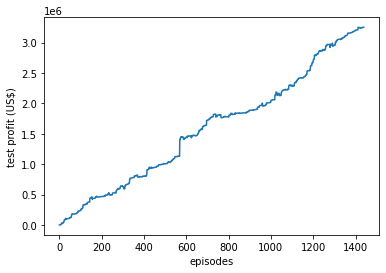

In [18]:
plt.plot(test_profits_record_per_episodes, linestyle = '-')
plt.ylabel('test profit (US$)')
plt.xlabel('episodes')

plt.show()

### Most lucrative market on test - Prices by time

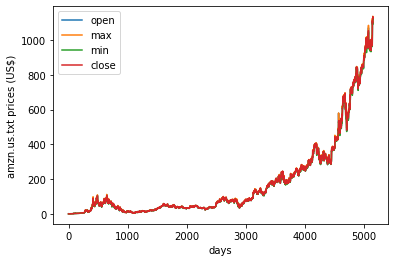

In [19]:
plot_market(test_max_market_profit[0], None)

### Most lucrative market on test - Profit by time

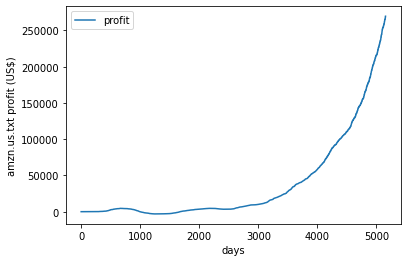

In [20]:
plot_market(test_max_market_profit[0], test_max_market_profit[2])

### Less lucrative market on test - Prices by time

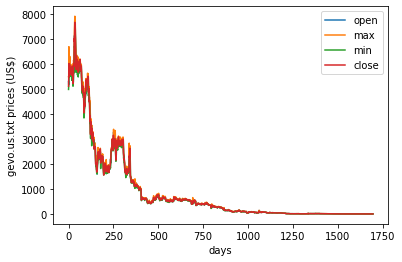

In [21]:
plot_market(test_min_market_profit[0], None)

### Less lucrative market on test - Profit by time

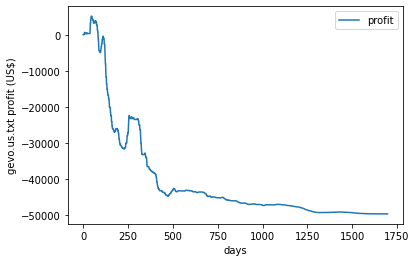

In [22]:
plot_market(test_min_market_profit[0], test_min_market_profit[2])

# Conclusion

It is possible to observe in graphs of results that profit by time has a movement similar to prices by time. That is, highest profits happen at times when the price is trending towards a top. The opposite occurs for lowest profits, which happen in times when price is tending towards a bottom. When prices are more stable, profits are also.

Finally, let's analyze the daily price chart of most and least profitable markets on test. In most profitable market we can see a flag sloping up in last 2000 days, it is also possible to notice up and down gaps, double tops and double bots in same timeframe, which was the period that the bot capitalized more. In less profitable market, there is a flag sloping down in first 500 days, including a down gap when the bot had its biggest expense. Double bots and double tops also occur in this period.

*Thank you so much for come until the end :)* 